Nicolas Brandstetter
Felipe Keim

Predicción de inicio y final de un evento de huso del sueño

In [143]:
#Imports
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
import os
import sys
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# loading data

In [144]:
test_marks = np.load('data_sigma_spindles/test_marks.npy')
test_signals = np.load('data_sigma_spindles/test_signals.npy')
train_marks = np.load('data_sigma_spindles/train_marks.npy')
train_signals = np.load('data_sigma_spindles/train_signals.npy')
val_marks = np.load('data_sigma_spindles/val_marks.npy')
val_signals = np.load('data_sigma_spindles/val_signals.npy')

In [145]:
scaler = StandardScaler()
scaler = scaler.fit(np.concatenate((test_signals,train_signals,val_signals)))

val_signals_normalized = scaler.transform(val_signals)
test_signals_normalized = scaler.transform(test_signals)
train_signals_normalized = scaler.transform(train_signals)

In [146]:
val_marks = torch.tensor(val_marks)
test_marks = torch.tensor(test_marks)
train_marks = torch.tensor(train_marks)

val_signals = torch.tensor(val_signals_normalized)
test_signals = torch.tensor(test_signals_normalized)
train_signals = torch.tensor(train_signals_normalized)

In [147]:
train_ds = torch.utils.data.TensorDataset(train_signals, train_marks)
val_ds = torch.utils.data.TensorDataset(val_signals, val_marks)
test_ds = torch.utils.data.TensorDataset(test_signals, test_marks)

## Creating Dataset

tensor([357, 472], dtype=torch.int32)


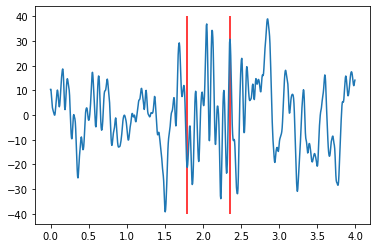

In [148]:
train_ds = torch.utils.data.TensorDataset(train_signals, train_marks)
val_ds = torch.utils.data.TensorDataset(val_signals, val_marks)
test_ds = torch.utils.data.TensorDataset(test_signals, test_marks)
a=np.load('data_sigma_spindles/train_signals.npy')
b=np.load('data_sigma_spindles/train_marks.npy')
t=np.arange(len(a[0]))*(4/800)
plt.plot(t,a[0])
plt.vlines(b[0]*(4/800),-40,40,colors="r")

print(train_ds[0][1])


# entrenamiento y visualización

## Curves

In [149]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()
    plt.show()


## IOU

In [150]:
SMOOTH = 1e-6

def iou_pytorch(y_predicted: torch.Tensor, y_vals: torch.Tensor,eva=False):

    largo=len(y_vals)
    error_array=np.zeros(largo)
    count=0
    for pred,y_val in zip(y_predicted,y_vals):
        pred=pred.squeeze(0)
        intervalo_inter = [max(pred[0],y_val[0]),min(pred[1],y_val[1])]
        rest = intervalo_inter[1] - intervalo_inter[0]
        inter = rest if rest>0 else 0

        len_predicted = pred[1] - pred[0]
        len_val = y_val[1] - y_val[0]
        union = len_predicted + len_val - inter
        error_array[count]=(inter/(union+1e-6))
        count+=1
        
    return torch.tensor(1-np.mean(error_array),requires_grad=True)

### IOU 2d

In [151]:
SMOOTH = 1e-6

def iou_pytorch2d(y_predicted, y_vals):
  
    largo=len(y_vals)
    error_array=np.zeros(largo)
    count=0

    y_predicted = y_predicted.unsqueeze(0)
    for pred,y_val in zip(y_predicted,y_vals):

        #calculamos interseccion
        intervalo_inter = [max(pred[0],y_val[0]),min(pred[1],y_val[1])]
        rest = intervalo_inter[1] - intervalo_inter[0]
        inter = rest if rest>0 else 0

        #calculamos union
        len_predicted = pred[1] - pred[0]
        len_val = y_val[1] - y_val[0]
        union = len_predicted + len_val - inter

        error_array[count]=(inter/(union+SMOOTH))
        count+=1
        
    return torch.tensor(1-np.mean(error_array),requires_grad=True), error_array

## Evaluation

In [152]:
def evaluate(val_loader, model, criterion, use_gpu,delta=0.1):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0
    y_predicted=[]
    error_list=[]
    for x_val, y_val in val_loader:
        for x,y in zip(x_val,y_val):   
            x=x.unsqueeze(0)
            x=x.unsqueeze(0)
            if use_gpu:
                x = x.cuda()
                y = y.cuda()
            y_pred=model(x)
            y_pred=y_pred.reshape(2)

            err=criterion(y_pred.unsqueeze(0),y.unsqueeze(0),eva=True)
            error_list.append(err)
            y_predicted.append(y_pred)
            cumulative_predictions += (err<delta)
            cumulative_loss += err

        data_count = x_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss # Hay que dividirla por algooo quizas el len

    return val_acc, val_loss

### Evaluation 2d

In [153]:
delta=0.1
def evaluate2d(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        batch_size = len(x_val)
        x_val = x_val.unsqueeze(0)
        #x_val = torch.reshape(x_val, (batch_size, 1, 800))

        y_predicted = model(x_val)
        
        loss, error_array = criterion(y_predicted, y_val)

        correct_prediction = (error_array > delta).sum()

        cumulative_predictions += correct_prediction
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss

## Training set up

### Train step 

In [154]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted=[]
    for pred in x_batch:
        pred=pred.unsqueeze(0)
        pred=pred.unsqueeze(0)
        y_predicted.append(model(pred))
        
    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss

#### Train step 2d

In [155]:
def train_step2d(x_batch, y_batch, model, optimizer, criterion, use_gpu):
     
    batch_size = len(x_batch)
    x_batch = x_batch.unsqueeze(0)
    #x_batch = torch.reshape(x_batch, (batch_size, 1, 800))
    y_predicted = model(x_batch)
    
    # Cálculo de loss
    loss, error_array = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss, error_array

### Train Model

In [156]:
def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
):

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # for i,x in enumerate(train_loader):
    #     a=[0,1,2,3,4]
    #     if i in a:
    #         print("loader: ",x[1])

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0


        # Entrenamiento del modelo
        model.train()

        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            #train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            #class_prediction = torch.argmax(y_predicted, axis=1).long()
            #cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                #train_acc = cumulative_train_corrects / train_acc_count

                # print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")
                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}")
            iteration += 1


        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        #train_acc = cumulative_train_corrects / train_acc_count

       # curves["train_acc"].append(train_acc)
        #curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    # if data_augmentation:
    #     train_dataset.dataset.transform = original_transform

    return curves

#### Train model 2d

In [157]:
delta = 0.1

def train_model2d(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    data_augmentation=False,
):

    if use_gpu:
        model.cuda()

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()

        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss, error_array = train_step2d(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            correct_prediction = (error_array > delta).sum()
            #class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += correct_prediction

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")
                #print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}")
            iteration += 1


        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate2d(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()

    # if data_augmentation:
    #     train_dataset.dataset.transform = original_transform

    return curves

# Models Definition

## Conv1dModel

In [158]:

class CNN1d_Model(nn.Module):
    eva=False
    def __init__(
        self,
        dropout_p,
        input_size=1,
        output_size=2,
    ):
        
        super().__init__()
        self.conv_blocks = nn.Sequential(
            
            nn.Conv1d(input_size, 1, kernel_size=1, stride=1, padding="same"),

            nn.Conv1d(input_size, 8, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(8, 16,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(16,32,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32,64,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64,128,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(5),

            nn.Conv1d(256,256,kernel_size=3, stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool1d(5),

            nn.Conv1d(256,2,kernel_size=3, stride = 1, padding="same"),
            
        )

    def forward(self, x,evaa=False):
        return self.conv_blocks(x)



## Conv2d Model

In [159]:
C=1
class CNN2d_Model(nn.Module):

    def __init__(
        self,
        dropout_p
    ):
        
        super().__init__()
        self.spatial_filtering = nn.Sequential(
            nn.Conv2d(1, C, kernel_size=(C, 1), stride=1),
        )

        self.conv_blocks = nn.Sequential(
            
            nn.Conv2d(1, 4, kernel_size=(1,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((1,2)),

            nn.Conv2d(4, 8, kernel_size=(1,3), stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((1,2)),

            nn.Conv2d(8, 16,kernel_size=(1,3), stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((1,2)),

            nn.Conv2d(16,32,kernel_size=(1,3), stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((1,2)),

            nn.Conv2d(32,64,kernel_size=(1,3), stride = 1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d((1,2)),

        )

        self.localization = nn.Sequential(
           
            nn.Conv2d(64, 2, kernel_size=(1, 25)),

        )

    def forward(self,x):
        x = self.spatial_filtering(x)
        #x = torch.transpose(x, 0, 1)
        x = self.conv_blocks(x)
        x = self.localization(x)
        x = torch.mean(x, dim=1)
        x = x.reshape(2)
        return x

# Training

In [160]:
lr = 5e-4
batch_size = 2
criterion = iou_pytorch
criterion2d= iou_pytorch2d
epochs = 2

In [163]:
CNN1d = CNN1d_Model(dropout_p=0.5)
curves = train_model(
    CNN1d,
    train_ds,
    val_ds,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=False,
    data_augmentation=False,
)
show_curves(curves)

Epoch 1/2
Iteration 372 - Batch 372/2232 - Train loss: 1.0
Iteration 744 - Batch 744/2232 - Train loss: 1.0
Iteration 1116 - Batch 1116/2232 - Train loss: 1.0
Iteration 1488 - Batch 1488/2232 - Train loss: 1.0
Iteration 1860 - Batch 1860/2232 - Train loss: 1.0


KeyboardInterrupt: 

Epoch 1/2
Iteration 372 - Batch 372/2232 - Train loss: 1.0, Train acc: 0.0
Iteration 744 - Batch 744/2232 - Train loss: 1.0, Train acc: 0.0
Iteration 1116 - Batch 1116/2232 - Train loss: 1.0, Train acc: 0.0
Iteration 1488 - Batch 1488/2232 - Train loss: 1.0, Train acc: 0.0
Iteration 1860 - Batch 1860/2232 - Train loss: 1.0, Train acc: 0.0
Val loss: 1.0, Val acc: 0.0
Epoch 2/2
Iteration 2604 - Batch 372/2232 - Train loss: 1.0, Train acc: 0.0
Iteration 2976 - Batch 744/2232 - Train loss: 1.0, Train acc: 0.0
Iteration 3348 - Batch 1116/2232 - Train loss: 1.0, Train acc: 0.0
Iteration 3720 - Batch 1488/2232 - Train loss: 1.0, Train acc: 0.0
Iteration 4092 - Batch 1860/2232 - Train loss: 1.0, Train acc: 0.0
Val loss: 1.0, Val acc: 0.0

Tiempo total de entrenamiento: 17.4104 [s]


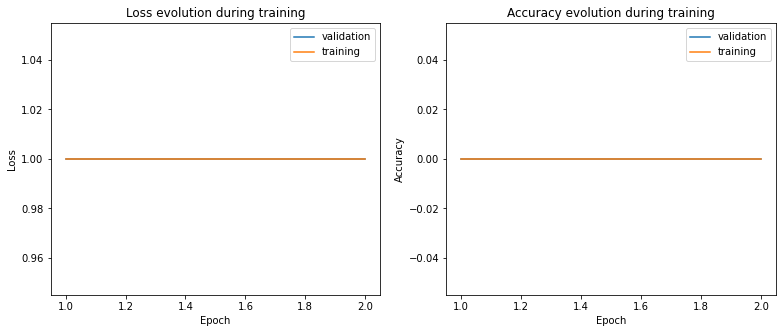

In [162]:
CNN2d = CNN2d_Model(dropout_p=0.5)
curves = train_model2d(
    CNN2d,
    train_ds,
    val_ds,
    epochs,
    criterion2d,
    batch_size,
    lr,
    use_gpu=False,
    data_augmentation=False,
)
show_curves(curves)